In [2]:
""" Given loss and parameters for optimizer, returns a training op """
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import variable_scope as vs
from tensorflow.python.ops import variables as vars_
from tensorflow.python.summary import summary
from tensorflow.python.training import moving_averages
from tensorflow.python.training import optimizer as optimizer_
from tensorflow.python.training import training as train
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import six

OPTIMIZER_CLS_NAMES = {
    "Adagrad": train.AdagradOptimizer,
    "Adam": train.AdamOptimizer,
    "Ftrl": train.FtrlOptimizer,
    "Momentum": lambda learning_rate: train.MomentumOptimizer(learning_rate, momentum=0.9),  # pylint: disable=line-too-long
    "RMSProp": train.RMSPropOptimizer,
    "SGD": train.GradientDescentOptimizer,}

OPTIMIZER_SUMMARIES = [
    "learning_rate",
    "loss",
    "gradients",
    "gradient_norm",
    "global_gradient_norm",]

def optimize_loss(loss, global_step, learning_rate, optimizer,
                  gradient_noise_scale=None,
                  gradient_multipliers=None,
                  clip_gradients=None,
                  learning_rate_decay_fn=None,
                  update_ops=None,
                  variables=None,
                  name=None,
                  summaries=None,
                  colocate_gradients_with_ops=False,
                  increment_global_step=True):

    loss = ops.convert_to_tensor(loss)
    if global_step is None:
        global_step = train.get_global_step()
    else:
        train.assert_global_step(global_step)
    
    with vs.variable_scope(name, "OptimizeLoss", [loss, global_step]):
        # Update ops take UPDATE_OPS collection if not provided
        if update_ops is None:
            update_ops = set(ops.get_collection(ops.GraphKeys.UPDATE_OPS))
        # Make sure update ops are ran before computing loss
        if update_ops:
            loss = control_flow_ops.with_dependencies(list(update_ops), loss)

        # Learning rate variable, with possible decay
        lr = None
        if learning_rate is not None:
            if isinstance(learning_rate, ops.Tensor) and learning_rate.get_shape().ndims == 0:
                lr = learning_rate
            elif isinstance(learning_rate, float):
                if learning_rate < 0.0:
                    raise ValueError("Invalid learning_rate %s.", learning_rate)
                lr = vs.get_variable("learning_rate", [], trainable=False, initializer=init_ops.constant_initializer(learning_rate))
            else:
                raise ValueError("Learning rate should be 0d Tensor or float. Got %s of type %s" % (str(learning_rate), str(type(learning_rate))))
        if summaries is None:
            summaries = ["loss", "learning_rate", "global_gradient_norm"]
        else:
            for summ in summaries:
                if summ not in OPTIMIZER_SUMMARIES:
                    raise ValueError("Summaries should be one of [%s], you provided %s." %(", ".join(OPTIMIZER_SUMMARIES), summ))
        if learning_rate is not None and learning_rate_decay_fn is not None:
            if global_step is None:
                raise ValueError("global_step is required for learning_rate_decay_fn.")
            lr = learning_rate_decay_fn(lr, global_step)
            if "learning_rate" in summaries:
                summary.scalar("learning_rate", lr)

        # Create optimizer, given specified parameters
        if isinstance(optimizer, six.string_types):
            if lr is None:
                raise ValueError("Learning rate is None, but should be specified if optimizer is string (%s)." % optimizer)
            if optimizer not in OPTIMIZER_CLS_NAMES:
                raise ValueError("Optimizer name should be one of [%s], you provided %s." %(", ".join(OPTIMIZER_CLS_NAMES), optimizer))
            opt = OPTIMIZER_CLS_NAMES[optimizer](learning_rate=lr)
        elif isinstance(optimizer, type) and issubclass(optimizer, optimizer_.Optimizer):
            if lr is None:
                raise ValueError("Learning rate is None, but should be specified if optimizer is class (%s)." % optimizer)
            opt = optimizer(learning_rate=lr)
        elif isinstance(optimizer, optimizer_.Optimizer):
            opt = optimizer
        elif callable(optimizer):
            if learning_rate is not None:
                opt = optimizer(lr)
            else:
                opt = optimizer()
            if not isinstance(opt, optimizer_.Optimizer):
                raise ValueError("Unrecognized optimizer: function should return subclass of Optimizer. Got %s." % str(opt))
        else:
            raise ValueError("Unrecognized optimizer: should be string, subclass of Optimizer, instance of "
                       "subclass of Optimizer or function with one argument. Got %s." % str(optimizer))

        # All trainable variables, if specific variables are not specified
        if variables is None:
            variables = vars_.trainable_variables()

        # Compute gradients
        gradients = opt.compute_gradients(loss, variables, colocate_gradients_with_ops=colocate_gradients_with_ops)

        # Optionally add gradient noise
        if gradient_noise_scale is not None:
            gradients = _add_scaled_noise_to_gradients(gradients, gradient_noise_scale)

        # Multiply some gradients
        if gradient_multipliers is not None:
            gradients = _multiply_gradients(gradients, gradient_multipliers)
            if not gradients:
                raise ValueError("Empty list of (gradient, var) pairs encountered. This is most "
                        "likely to be caused by an improper value of gradient_multipliers.")

        if "global_gradient_norm" in summaries or "gradient_norm" in summaries:
            summary.scalar("global_norm/gradient_norm", clip_ops.global_norm(list(zip(*gradients))[0]))

        # Optionally clip gradients by global norm
        if isinstance(clip_gradients, float):
            gradients = clip_gradients_by_norm(gradients, clip_gradients)
        elif callable(clip_gradients):
            gradients = clip_gradients(gradients)
        elif clip_gradients is not None:
            raise ValueError("Unknown type %s for clip_gradients" % type(clip_gradients))

        # Add scalar summary for loss
        if "loss" in summaries:
            summary.scalar("loss", loss)

        # Add histograms for variables, gradients and gradient norms
        for gradient, variable in gradients:
            if isinstance(gradient, ops.IndexedSlices):
                grad_values = gradient.values
            else:
                grad_values = gradient

            if grad_values is not None:
                var_name = variable.name.replace(":", "_")
                if "gradients" in summaries:
                    summary.histogram("gradients/%s" % var_name, grad_values)
                if "gradient_norm" in summaries:
                    summary.scalar("gradient_norm/%s" % var_name, clip_ops.global_norm([grad_values]))

        if clip_gradients is not None and ("global_gradient_norm" in summaries or "gradient_norm" in summaries):
            summary.scalar("global_norm/clipped_gradient_norm", clip_ops.global_norm(list(zip(*gradients))[0]))

        # Create gradient updates
        grad_updates = opt.apply_gradients(gradients, global_step=global_step if increment_global_step else None, name="train")

        # Ensure the train_tensor computes grad_updates
        train_tensor = control_flow_ops.with_dependencies([grad_updates], loss)
        return train_tensor

""" Clips gradients by global norm """
def clip_gradients_by_norm(grads_and_vars, clip_gradients):
    gradients, variables = zip(*grads_and_vars)
    clipped_gradients, _ = clip_ops.clip_by_global_norm(gradients, clip_gradients)
    return list(zip(clipped_gradients, variables))

""" Find max_norm given norm and previous average """
def adaptive_max_norm(norm, std_factor, decay, global_step, epsilon, name):

    with vs.variable_scope(name, "AdaptiveMaxNorm", [norm]):
        log_norm = math_ops.log(norm + epsilon)

        def moving_average(name, value, decay):
            moving_average_variable = vs.get_variable(name, shape=value.get_shape(), dtype=value.dtype, initializer=init_ops.zeros_initializer(), trainable=False)
            return moving_averages.assign_moving_average(moving_average_variable, value, decay, zero_debias=False)

        # Quicker adaptation at the beginning
        if global_step is not None:
            n = math_ops.to_float(global_step)
            decay = math_ops.minimum(decay, n / (n + 1.))

        # Update averages
        mean = moving_average("mean", log_norm, decay)
        sq_mean = moving_average("sq_mean", math_ops.square(log_norm), decay)
        variance = sq_mean - math_ops.square(mean)
        std = math_ops.sqrt(math_ops.maximum(epsilon, variance))
        max_norms = math_ops.exp(mean + std_factor * std)

        return max_norms, mean

""" Adapt the clipping value using statistics on the norms """
def adaptive_clipping_fn(std_factor=2., decay=0.95, static_max_norm=None, global_step=None, report_summary=False, epsilon=1e-8, name=None):

    """ Internal function for adaptive clipping """
    # Keeps a moving average of the mean and std of the log(norm) of the gradient.
    # If the norm exceeds `exp(mean + std_factor*std)` then all gradients will be rescaled such that the global norm becomes `exp(mean)`.
    def gradient_clipping(grads_and_vars):

        grads, variables = zip(*grads_and_vars)
        norm = clip_ops.global_norm(grads)
        max_norm, log_mean = adaptive_max_norm(norm, std_factor, decay, global_step, epsilon, name)

        # Reports the max gradient norm for debugging
        if report_summary:
            summary.scalar("global_norm/adaptive_max_gradient_norm", max_norm)

        # Factor will be 1, if norm is smaller than max_norm
        factor = array_ops.where(norm < max_norm, array_ops.ones_like(norm), math_ops.exp(log_mean) / norm)
        if static_max_norm is not None:
            factor = math_ops.minimum(static_max_norm / norm, factor)

        # Apply factor
        clipped_grads = []
        for grad in grads:
            if grad is None:
                clipped_grads.append(None)
            elif isinstance(grad, ops.IndexedSlices):
                clipped_grads.append(ops.IndexedSlices(grad.values * factor, grad.indices, grad.dense_shape))
            else:
                clipped_grads.append(grad * factor)

        return list(zip(clipped_grads, variables))

    return gradient_clipping

""" Adds scaled noise from a 0-mean normal distribution to gradients """
def _add_scaled_noise_to_gradients(grads_and_vars, gradient_noise_scale):

    gradients, variables = zip(*grads_and_vars)
    noisy_gradients = []
    for gradient in gradients:
        if gradient is None:
            noisy_gradients.append(None)
            continue
        if isinstance(gradient, ops.IndexedSlices):
            gradient_shape = gradient.dense_shape
        else:
            gradient_shape = gradient.get_shape()
        noise = random_ops.truncated_normal(gradient_shape) * gradient_noise_scale
        noisy_gradients.append(gradient + noise)
    
    return list(zip(noisy_gradients, variables))

""" Multiply specified gradients """
def _multiply_gradients(grads_and_vars, gradient_multipliers):
    multiplied_grads_and_vars = []
    for grad, var in grads_and_vars:
        if grad is not None and (var in gradient_multipliers or var.name in gradient_multipliers):
            key = var if var in gradient_multipliers else var.name
            multiplier = constant_op.constant(gradient_multipliers[key], dtype=dtypes.float32)
            if isinstance(grad, ops.IndexedSlices):
                grad_values = grad.values * multiplier
                grad = ops.IndexedSlices(grad_values, grad.indices, grad.dense_shape)
            else:
                grad *= multiplier
        multiplied_grads_and_vars.append((grad, var))
    
    return multiplied_grads_and_vars

In [3]:
""" Bi-directional LSTM model class """
from tensorflow.compat import v1 as tfc

class BiLSTMTextRelation:
    def __init__(self, num_classes, learning_rate, batch_size, decay_steps, decay_rate, sequence_length, vocab_size,
                 embed_size, is_training, block_unit=32, initializer=tfc.random_normal_initializer(stddev=0.1)):

        # Initilize all hyperparameters
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = block_unit
        self.is_training = is_training
        self.learning_rate = learning_rate
        self.initializer = initializer

        # Add placeholder (X, label), used to feed actual training examples to the model ==> X: input_x, label: input_y
        self.input_x = tfc.placeholder(tfc.int32, [None, self.sequence_length], name="input_x") # X:  concat of word vectors
        self.input_y = tfc.placeholder(tfc.int32, [None], name="input_y")  # y [None, num_classes]
        self.dropout_keep_prob = tfc.placeholder(tfc.float32, name="dropout_keep_prob")

        # Add trainable variables such as step, epoch and bias etc. for the model
        self.global_step = tfc.Variable(0, trainable=False, name="Global_Step")
        self.epoch_step = tfc.Variable(0, trainable=False, name="Epoch_Step")
        self.epoch_increment = tfc.assign(self.epoch_step, tfc.add(self.epoch_step, tfc.constant(1)))
        self.decay_steps, self.decay_rate = decay_steps, decay_rate

        # Initialize all weights
        self.instantiate_weights()

        # Build main graph
        self.logits = self.inference() # [None, self.num_classes]
        if not is_training:
            return
        self.loss_val = self.loss() # Compute 1-D `Tensor` of length `batch_size` of the same type as `logits` with the softmax cross entropy loss
        self.train_op = self.train() # Based on the loss, update model parameters
        self.predictions = tfc.argmax(self.logits, axis=1, name="Predictions")  # shape:[None, ]
        correct_prediction = tfc.equal(tfc.cast(self.predictions, tfc.int32), self.input_y) # shape:[batch_size]
        self.accuracy = tfc.reduce_mean(tfc.cast(correct_prediction, tfc.float32), name="Accuracy") # shape=()

    def instantiate_weights(self):
        # Define all weights for the model
        with tfc.name_scope("embedding"): # Embedding matrix
            self.Embedding = tfc.get_variable("Embedding", shape=[self.vocab_size, self.embed_size], initializer=self.initializer)
            self.W_projection = tfc.get_variable("W_projection", shape=[self.hidden_size*2, self.num_classes], initializer=self.initializer) # [embed_size,label_size]
            self.b_projection = tfc.get_variable("b_projection", shape=[self.num_classes]) # [label_size]

    def inference(self):
        # Primary computation graph structure: 1. embeddding layer, 2.bi-LSTM layer, 3.mean pooling, 4.FC layer/ softmax function
        # Process 1) Get emebedding of words in the sentence
        print("Adding Layer 1: Embedding of words")
        self.embedded_words = tfc.nn.embedding_lookup(self.Embedding, self.input_x) # shape:[None, sentence_length, embed_size]

        # Process 2) LSTM layer (forward + backward) ==> define lstm cell : get lstm cell output
        print("Adding Layer 2: LSTM layer (forward + backward)")
        lstm_fw_cell = tfc.nn.rnn_cell.BasicLSTMCell(self.hidden_size) # forward direction cell
        lstm_bw_cell = tfc.nn.rnn_cell.BasicLSTMCell(self.hidden_size) # backward direction cell
        if self.dropout_keep_prob is not None:
            lstm_fw_cell = tfc.nn.rnn_cell.DropoutWrapper(lstm_fw_cell, output_keep_prob=self.dropout_keep_prob)
            lstm_bw_cell = tfc.nn.rnn_cell.DropoutWrapper(lstm_bw_cell, output_keep_prob=self.dropout_keep_prob)
        # Bidirectional Dynamic RNN:
        #   input: [batch_size, max_time, input_size]
        #   output: A tuple (outputs, output_states)
        #           where, outputs is a tuple (output_fw, output_bw) containing the forward and the backward RNN output `Tensor`.
        # Creates dynamic bidirectional recurrent neural network
        outputs, _ = tfc.nn.bidirectional_dynamic_rnn(lstm_fw_cell, lstm_bw_cell, self.embedded_words, dtype=tfc.float32) # [batch_size, sequence_length, hidden_size]
        
        # Print outputs:(<tf.Tensor 'bidirectional_rnn/fw/fw/transpose_1:0' shape=(None, 2226, 100) dtype=float32>, <tf.Tensor 'ReverseV2:0' shape=(None, 2226, 100) dtype=float32>)
        print("\toutputs ==> ", outputs)
        
        # Process 3) Concat outputs
        print("Adding Layer 3: Output layer (mean pooling)")
        output_rnn = tfc.concat(outputs, axis=2) #[batch_size, sequence_length, hidden_size*2]
        output_rnn_pooled = tfc.reduce_mean(output_rnn, axis=1) #[batch_size, hidden_size*2], output_rnn_last = output_rnn[:, -1, :]
        # Print output_rnn_pooled: Tensor("Mean:0", shape=(None, 200), dtype=float32)
        print("\toutput_rnn_pooled ==> ", output_rnn_pooled)

        # Process 4) logits (using linear layer)
        print("Adding Layer 4: FC layer (linear softmax logits)")
        with tfc.name_scope("output"): #  inputs: A `Tensor` of shape `[batch_size, dim]`.  The forward activations of the input network.
            logits = tfc.matmul(output_rnn_pooled, self.W_projection) + self.b_projection  # [batch_size, num_classes]

        return logits

    def loss(self, l2_lambda=0.0001):
        with tfc.name_scope("loss"):
            # input: `logits` and `labels` having the same shape `[batch_size, num_classes]`
            # output: A 1-D `Tensor` of length `batch_size` of the same type as `logits` with the softmax cross entropy loss
            # or use sigmoid_cross_entropy_with_logits, then losses = tf.nn.softmax_cross_entropy_with_logits(labels=self.input_y,logits=self.logits)
            losses = tfc.nn.sparse_softmax_cross_entropy_with_logits(labels=self.input_y, logits=self.logits);

            # Print sparse_softmax_cross_entropy_with_logits.losses:  Tensor("loss/SparseSoftmaxCrossEntropyWithLogits:0", shape=(None,), dtype=float32)
            print("\tsparse_softmax_cross_entropy_with_logits.losses: ", losses)

            loss = tfc.reduce_mean(losses)
            print("\tlosses.loss: ", loss) # losses.loss:  Tensor("loss/Mean:0", shape=(), dtype=float32)
            l2_losses = tfc.add_n([tfc.nn.l2_loss(v) for v in tfc.trainable_variables() if 'bias' not in v.name]) * l2_lambda
            loss = loss + l2_losses

        return loss

    def train(self):
        # Based upon the loss, use any SGD optimizer to update parameters
        learning_rate = tfc.train.exponential_decay(self.learning_rate, self.global_step, self.decay_steps, self.decay_rate, staircase=True)
        # Apply Adam Gradient Descent loss optimization
        train_op = optimize_loss(self.loss_val, global_step=self.global_step, learning_rate=learning_rate, optimizer="Adam")

        return train_op

In [4]:
""" Bi-directional GRU model class """
from tensorflow.compat import v1 as tfc

class BiGRUTextRelation:
    def __init__(self, num_classes, learning_rate, batch_size, decay_steps, decay_rate, sequence_length, vocab_size,
                 embed_size, is_training, block_unit=32, initializer=tfc.random_normal_initializer(stddev=0.1)):

        # Initilize all hyperparameters
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = block_unit
        self.is_training = is_training
        self.learning_rate = learning_rate
        self.initializer = initializer

        # Add placeholder (X, label), used to feed actual training examples to the model ==> X: input_x, label: input_y
        self.input_x = tfc.placeholder(tfc.int32, [None, self.sequence_length], name="input_x")  # X:  concat of sentences
        self.input_y = tfc.placeholder(tfc.int32, [None], name="input_y")  # y [None, num_classes]
        self.dropout_keep_prob = tfc.placeholder(tfc.float32, name="dropout_keep_prob")

        # Add trainable variables such as step, epoch and bias etc. for the model
        self.global_step = tfc.Variable(0, trainable=False, name="Global_Step")
        self.epoch_step = tfc.Variable(0, trainable=False, name="Epoch_Step")
        self.epoch_increment = tfc.assign(self.epoch_step, tfc.add(self.epoch_step, tfc.constant(1)))
        self.decay_steps, self.decay_rate = decay_steps, decay_rate

        # Initialize all weights
        self.instantiate_weights()

        # Build main graph
        self.logits = self.inference() # [None, self.num_classes]
        if not is_training:
            return
        self.loss_val = self.loss() # Compute 1-D `Tensor` of length `batch_size` of the same type as `logits` with the softmax cross entropy loss
        self.train_op = self.train() # Based on the loss, update model parameters
        self.predictions = tfc.argmax(self.logits, axis=1, name="Predictions")  # shape:[None, ]
        correct_prediction = tfc.equal(tfc.cast(self.predictions, tfc.int32), self.input_y) # shape:[batch_size]
        self.accuracy = tfc.reduce_mean(tfc.cast(correct_prediction, tfc.float32), name="Accuracy") # shape=()

    def instantiate_weights(self):
        # Define all weights for the model
        with tfc.name_scope("embedding"): # Embedding matrix
            self.Embedding = tfc.get_variable("Embedding", shape=[self.vocab_size, self.embed_size], initializer=self.initializer)
            self.W_projection = tfc.get_variable("W_projection", shape=[self.hidden_size*2, self.num_classes], initializer=self.initializer) # [embed_size,label_size]
            self.b_projection = tfc.get_variable("b_projection", shape=[self.num_classes]) # [label_size]

    def inference(self):
        # Primary computation graph structure: 1. embeddding layer, 2.bi-GRU layer, 3.mean pooling, 4.FC layer/ softmax function
        # Process 1) Get emebedding of words in the sentence
        print("Adding Layer 1: Embedding of words")
        self.embedded_words = tfc.nn.embedding_lookup(self.Embedding, self.input_x) # shape:[None, sentence_length, embed_size]

        # Process 2) GRU layer (forward + backward) ==> define gru cell : get gru cell output
        print("Adding Layer 2: GRU layer (forward + backward)")
        gru_fw_cell = tfc.nn.rnn_cell.GRUCell(self.hidden_size) # forward direction cell
        gru_bw_cell = tfc.nn.rnn_cell.GRUCell(self.hidden_size) # backward direction cell
        if self.dropout_keep_prob is not None:
            gru_fw_cell = tfc.nn.rnn_cell.DropoutWrapper(gru_fw_cell, output_keep_prob=self.dropout_keep_prob)
            gru_bw_cell = tfc.nn.rnn_cell.DropoutWrapper(gru_bw_cell, output_keep_prob=self.dropout_keep_prob)
        # Bidirectional Dynamic RNN:
        #   input: [batch_size, max_time, input_size]
        #   output: A tuple (outputs, output_states)
        #           where, outputs is a tuple (output_fw, output_bw) containing the forward and the backward RNN output `Tensor`.
        # Creates dynamic bidirectional recurrent neural network
        outputs, _ = tfc.nn.bidirectional_dynamic_rnn(gru_fw_cell, gru_bw_cell, self.embedded_words, dtype=tfc.float32) # [batch_size, sequence_length, hidden_size]
        
        # Print outputs:(<tf.Tensor 'bidirectional_rnn/fw/fw/transpose_1:0' shape=(None, 2226, 100) dtype=float32>, <tf.Tensor 'ReverseV2:0' shape=(None, 2226, 100) dtype=float32>)
        print("\toutputs ==> ", outputs)
        
        # Process 3) Concat outputs
        print("Adding Layer 3: Output layer (mean pooling)")
        output_rnn = tfc.concat(outputs, axis=2) #[batch_size, sequence_length, hidden_size*2]
        output_rnn_pooled = tfc.reduce_mean(output_rnn, axis=1) #[batch_size, hidden_size*2], output_rnn_last = output_rnn[:, -1, :]
        # Print output_rnn_pooled: Tensor("Mean:0", shape=(None, 200), dtype=float32)
        print("\toutput_rnn_pooled ==> ", output_rnn_pooled)

        # Process 4) logits (using linear layer)
        print("Adding Layer 4: FC layer (linear softmax logits)")
        with tfc.name_scope("output"): #  inputs: A `Tensor` of shape `[batch_size, dim]`.  The forward activations of the input network.
            logits = tfc.matmul(output_rnn_pooled, self.W_projection) + self.b_projection  # [batch_size, num_classes]

        return logits

    def loss(self, l2_lambda=0.0001):
        with tfc.name_scope("loss"):
            # input: `logits` and `labels` having the same shape `[batch_size, num_classes]`
            # output: A 1-D `Tensor` of length `batch_size` of the same type as `logits` with the softmax cross entropy loss
            # or use sigmoid_cross_entropy_with_logits, then losses = tf.nn.softmax_cross_entropy_with_logits(labels=self.input_y,logits=self.logits)
            losses = tfc.nn.sparse_softmax_cross_entropy_with_logits(labels=self.input_y, logits=self.logits);

            # Print sparse_softmax_cross_entropy_with_logits.losses:  Tensor("loss/SparseSoftmaxCrossEntropyWithLogits:0", shape=(None,), dtype=float32)
            print("\tsparse_softmax_cross_entropy_with_logits.losses: ", losses)

            loss = tfc.reduce_mean(losses)
            print("\tlosses.loss: ", loss) # losses.loss:  Tensor("loss/Mean:0", shape=(), dtype=float32)
            l2_losses = tfc.add_n([tfc.nn.l2_loss(v) for v in tfc.trainable_variables() if 'bias' not in v.name]) * l2_lambda
            loss = loss + l2_losses

        return loss

    def train(self):
        # Based upon the loss, use any SGD optimizer to update parameters
        learning_rate = tfc.train.exponential_decay(self.learning_rate, self.global_step, self.decay_steps, self.decay_rate, staircase=True)
        # Apply Adam Gradient Descent loss optimization
        train_op = optimize_loss(self.loss_val, global_step=self.global_step, learning_rate=learning_rate, optimizer="Adam")

        return train_op

In [5]:
""" Data pre-processing functions """
import pandas as pd
import csv
import nltk
nltk.download('popular')
import inflect
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder

def tokenize(text):
    """Tokenize tweet into words"""
    return nltk.word_tokenize(text)

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize_text(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_verbs(words)
    return words

def get_clean_data(url):
    df = pd.read_csv(url, encoding='utf-8', sep='\t', quoting=csv.QUOTE_NONE)
    all_columns = ',Article,Class'
    all_classes = ['business', 'entertainment', 'politics', 'sport', 'tech']
    articles, classes = [], []
    current_article = ""
    current_length = 0
    article_max_length = 0
    for str in df[all_columns]:
        # process individual lines
        # mark start of any artcile in the text
        words = str.split(",\"")
        if words[0].isnumeric():
            str = str[(len(words[0]) + 1) : ]

        # get class of article
        words = str.split("\",")
        last_word = words[len(words) - 1]
        if any(last_word == s for s in all_classes):
            classes.append(last_word)
            str = str[0 : (len(str) - len(last_word) - 1)]
            words = normalize_text(tokenize(str))
            current_article = current_article + " " + " ".join([x for x in words])
            current_length = current_length + len(words)
            article_max_length = max(article_max_length, current_length)
            articles.append(current_article)
            current_article = ""
            current_length = 0
        else:
            words = normalize_text(tokenize(str))
            current_article = current_article + " " + " ".join([x for x in words])
            current_length = current_length + len(words)

    print("Maximum sequence length in properly processed articles = %s" % article_max_length)
    return articles, classes, article_max_length

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [6]:
""" Prepare dataset with normilzed text, numerical labeling and word indexing """
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Denoising text by removing non-ascii chars, stop words and punctuations along with lowercasing etc.
def preprocess_data(input_file_path, reuse):
    if reuse:
        return dataset, max_length
    articles, classes, max_len = get_clean_data(input_file_path)
    labels = LabelEncoder().fit_transform(classes)
    dfs = pd.DataFrame(list(zip(articles, labels)), columns=['article', 'class'])
    print("Total data entries = " + repr(dfs.shape))
    print(dfs.head())
    return dfs, max_len

def create_vocabulary(X_train, X_validate, X_test, MAX_NB_WORDS=100000, MAX_SEQUENCE_LENGTH=500, seed_val=1):

    # Tokenize training/ validation dataset
    np.random.seed(seed_val)
    training_texts = np.array(np.concatenate((X_train, X_validate), axis=0))
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token="<OOV>")
    tokenizer.fit_on_texts(training_texts)
    training_sequences = tokenizer.texts_to_sequences(training_texts)
    word_index = tokenizer.word_index    
    training_texts = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    print("\tFound %s unique tokens in training/ validation dataset." % len(word_index))
    indices = np.arange(training_texts.shape[0])
    training_texts = training_texts[indices]
    print("\tIndexed %s texts in training/ validation dataset." % training_texts.shape[0])
    X_train_Glove = training_texts[0 : len(X_train), ]
    X_validate_Glove = training_texts[len(X_train) : , ]

    # Tokenize test dataset
    test_sequences = tokenizer.texts_to_sequences(np.array(X_test))
    test_texts = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    indices = np.arange(test_texts.shape[0])
    X_test_Glove = test_texts[indices]

    # Build embedding dictionary
    embeddings_dict = {} # Embedding size = 100
    f = open("/content/glove.6B.100d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print("\tTotal %s word vectors in Glove embedding dictionary." % len(embeddings_dict))
    
    return (X_train_Glove, X_validate_Glove, X_test_Glove, word_index, embeddings_dict)

input_file_path = 'https://raw.githubusercontent.com/vedpsingh/test/main/bbc.csv'
dataset, max_length = preprocess_data(input_file_path, False)

Maximum sequence length in properly processed articles = 2226
Total data entries = (1912, 2)
                                             article  class
0   ad sales boost time warner profit quarterly p...      0
1   dollar gain greenspan speech dollar hit highe...      0
2   yukos unit buyer face loan claim owners embat...      0
3   high fuel price hit ba profit british airways...      0
4   pernod takeover talk lift domecq share uk dri...      0


Step 1) Load processed data ==> normalize articles, randomally shuffle and split
	Count of training labled article = 1338
	Count of validating labled articles = 191
	Count of testing labled articles = 383

Step 2) Represent articles with padded vectors of word indices ==> tokenize to get word:index lists and padded sequences
	Found 23252 unique tokens in training/ validation dataset.
	Indexed 1529 texts in training/ validation dataset.
	Total 400000 word vectors in Glove embedding dictionary.
	Vocabulary size =  23253
{'<OOV>': 1, 'say': 2, 'mr': 3, 'would': 4, 'people': 5, 'make': 6, 'also': 7, 'us': 8, 'new': 9, 'year': 10, 'one': 11, 'take': 12, 'use': 13, 'could': 14, 'go': 15, 'get': 16, 'time': 17, 'government': 18, 'last': 19, 'company': 20, 'film': 21, 'show': 22, 'game': 23, 'uk': 24, 'come': 25, 'work': 26, 'firm': 27, 'world': 28, 'tell': 29, 'first': 30, 'market': 31, 'two': 32, 'nt': 33, 'plan': 34, 'music': 35, 'see': 36, 'service': 37, 'include': 38, 'years': 39, 'want':

W0219 10:40:23.655299 140217832449920 deprecation.py:339] From <ipython-input-3-5591785e3cc6>:68: bidirectional_dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API


Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


W0219 10:40:23.665759 140217832449920 deprecation.py:339] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/rnn.py:447: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W0219 10:40:23.752872 140217832449920 deprecation.py:537] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:753: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


	outputs ==>  (<tf.Tensor 'bidirectional_rnn/fw/fw/transpose_1:0' shape=(None, 2226, 32) dtype=float32>, <tf.Tensor 'ReverseV2:0' shape=(None, 2226, 32) dtype=float32>)
Adding Layer 3: Output layer (mean pooling)
	output_rnn_pooled ==>  Tensor("Mean:0", shape=(None, 64), dtype=float32)
Adding Layer 4: FC layer (linear softmax logits)
	sparse_softmax_cross_entropy_with_logits.losses:  Tensor("loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:0", shape=(None,), dtype=float32)
	losses.loss:  Tensor("loss/Mean:0", shape=(), dtype=float32)

	Initializing model variables...
	Using pre-trained word emebedding from standford source: "Global Vectors for Word Representation"

	Training vocabulary (words) ==>
	 ['<OOV>', 'say', 'mr', 'would', 'people', 'make', 'also', 'us', 'new', 'year', 'one', 'take', 'use', 'could', 'go', 'get', 'time', 'government', 'last', 'company', 'film', 'show', 'game', 'uk', 'come', 'work', 'firm', 'world', 'tell', 'first', 'market', 'two', 'n

W0219 10:44:52.395730 140217832449920 deprecation.py:537] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:577: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


	outputs ==>  (<tf.Tensor 'bidirectional_rnn/fw/fw/transpose_1:0' shape=(None, 2226, 32) dtype=float32>, <tf.Tensor 'ReverseV2:0' shape=(None, 2226, 32) dtype=float32>)
Adding Layer 3: Output layer (mean pooling)
	output_rnn_pooled ==>  Tensor("Mean:0", shape=(None, 64), dtype=float32)
Adding Layer 4: FC layer (linear softmax logits)
	sparse_softmax_cross_entropy_with_logits.losses:  Tensor("loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:0", shape=(None,), dtype=float32)
	losses.loss:  Tensor("loss/Mean:0", shape=(), dtype=float32)

	Deleting previously stored variables from checkpoint for RNN based gru model.

	Initializing model variables...
	Using pre-trained word emebedding from standford source: "Global Vectors for Word Representation"

	Training vocabulary (words) ==>
	 ['<OOV>', 'say', 'mr', 'would', 'people', 'make', 'also', 'us', 'new', 'year', 'one', 'take', 'use', 'could', 'go', 'get', 'time', 'government', 'last', 'company', 'film', 'show', 'ga

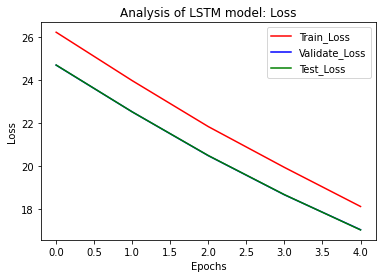

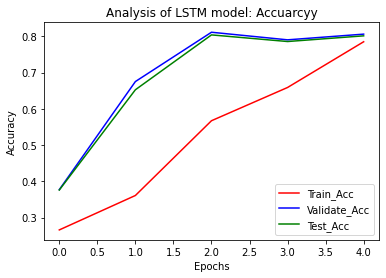

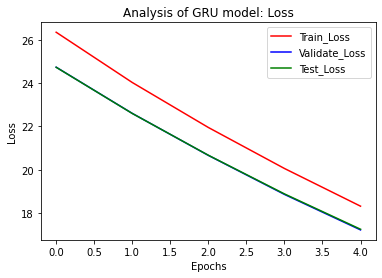

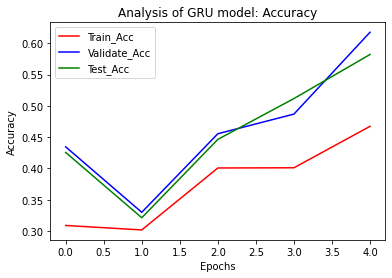

SystemExit: ignored

In [7]:
import sys
import os
import numpy as np
import random
from statistics import mean
import shutil
from tensorflow.compat import v1 as tfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

""" Configuration of model training """
num_labels = 5
learn_rate = 0.01
size_batch = 512 # batch size for training/ evaluating
decay_steps_count = 12000 # how many steps before decay learning rate
decaying_rate = 0.90 # rate of decay for learning rate
dropout_prob = 0.6
size_embedding = 100 # embedding size
embedding = True # whether to use embedding or not
hidden_units = 32 # hidden units within each BiLSTM or BiGRU layer
epochs = 5

""" Input dataset and tensorflow parameters """
input_file_path = 'https://raw.githubusercontent.com/vedpsingh/test/main/bbc.csv'
# Use 70:10:20 split for training, validation and testing
train_ratio =  0.70
validate_ratio = 0.10
test_ratio = 0.20
ckpt_dir_lstm = "LSTM_text_relation_checkpoint/" # checkpoint location for the LSTM model
ckpt_dir_gru = "GRU_text_relation_checkpoint/" # checkpoint location for the GRU model
test_every = 1 # Test after every epoch
reuse = False # whether to reuse previously trained model
training = True # traning==> true:tranining, false:testing/ inference

# Process 1) Load data (X:list of lint, y:int) and spliting
# Process 2) Creating vocabulary along with padding
# Process 3) Create session (tensorflow)
# Process 4) Feed data and training
# Process 5) Testing
# Process 6) Prediction/ Validation

def main(_):
    # Process 1) Load data (X:list of lint, y:int) and spliting of X and y
    print('Step 1) Load processed data ==> normalize articles, randomally shuffle and split')
    X_train, y_train, X_validate, y_validate, X_test, y_test = None, None, None, None, None, None
    dataset, max_length = preprocess_data(input_file_path, True)
    training_size = int(dataset.shape[0] * train_ratio)
    validation_size = int(dataset.shape[0] * validate_ratio)
    testing_size = int(dataset.shape[0] * test_ratio)

    # Shuffle entire dataset randomly (in-place)
    processed_data = dataset.sample(frac=1).reset_index(drop=True)
    X = processed_data['article'].tolist()
    y = processed_data['class'].tolist()
    # First, randomly select training dataset portion
    X_train, X_validate_test, y_train, y_validate_test = train_test_split(X, y, train_size=training_size,
                                                          test_size=(processed_data.shape[0] - training_size))
    # Secondly, seperate testing and validation dataset portions from the remaining dataset (after extracting training dataset portion)
    X_validate = X_validate_test[0 : validation_size]
    y_validate = y_validate_test[0 : validation_size]
    X_test = X_validate_test[validation_size: ]
    y_test = y_validate_test[validation_size: ]

    print("\tCount of training labled article = " + repr(len(X_train)))
    print("\tCount of validating labled articles = " + repr(len(X_validate)))
    print("\tCount of testing labled articles = " + repr(len(X_test)))

    # Process 2) Artcile texts indexing along with sequence padding
    print('\nStep 2) Represent articles with padded vectors of word indices ==> tokenize to get word:index lists and padded sequences')
    X_train_Glove, X_validate_Glove, X_test_Glove, vocabulary_word_index, embeddings_dict = create_vocabulary(X_train,
                                                                                                              X_validate,
                                                                                                              X_test,
                                                                                                              MAX_SEQUENCE_LENGTH=max_length)
    size_vocab = len(vocabulary_word_index) + 1 # Include first word '_PAD' (zeroes) too
    print("\tVocabulary size = ", size_vocab)
    print(vocabulary_word_index)

    train_ls_lstm, validate_ls_lstm, test_ls_lstm, train_acc_lstm, validate_acc_lstm, test_acc_lstm = run_tf_session(X_train_Glove,
                                                                      y_train, X_validate_Glove, y_validate, X_test_Glove, y_test,
                                                                      vocabulary_word_index, size_vocab, embeddings_dict, "lstm")
    train_ls_gru, validate_ls_gru, test_ls_gru, train_acc_gru, validate_acc_gru, test_acc_gru = run_tf_session(X_train_Glove,
                                                                      y_train, X_validate_Glove, y_validate, X_test_Glove, y_test,
                                                                      vocabulary_word_index, size_vocab, embeddings_dict, "gru")
    
    # Plot all types of accuracy for LSTM model
    plt.plot(list(range(epochs)), train_ls_lstm, label='Train_Loss', color='r')
    plt.plot(list(range(epochs)), validate_ls_lstm, label='Validate_Loss', color='b')
    plt.plot(list(range(epochs)), test_ls_lstm, label='Test_Loss', color='g')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Analysis of LSTM model: Loss')
    plt.legend()
    plt.show()

    plt.plot(list(range(epochs)), train_acc_lstm, label='Train_Acc', color='r')
    plt.plot(list(range(epochs)), validate_acc_lstm, label='Validate_Acc', color='b')
    plt.plot(list(range(epochs)), test_acc_lstm, label='Test_Acc', color='g')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Analysis of LSTM model: Accuarcyy')
    plt.legend()
    plt.show()

    # Plot all types of accuracy for GRU model
    plt.plot(list(range(epochs)), train_ls_gru, label='Train_Loss', color='r')
    plt.plot(list(range(epochs)), validate_ls_gru, label='Validate_Loss', color='b')
    plt.plot(list(range(epochs)), test_ls_gru, label='Test_Loss', color='g')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Analysis of GRU model: Loss')
    plt.legend()
    plt.show()

    plt.plot(list(range(epochs)), train_acc_gru, label='Train_Acc', color='r')
    plt.plot(list(range(epochs)), validate_acc_gru, label='Validate_Acc', color='b')
    plt.plot(list(range(epochs)), test_acc_gru, label='Test_Acc', color='g')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Analysis of GRU model: Accuracy')
    plt.legend()
    plt.show()
    pass

""" Run the model with specific cell_type (as lstm or gru) """
def run_tf_session(X_train_Glove, y_train, X_validate_Glove, y_validate, X_test_Glove, y_test,
                   vocabulary_word_index, size_vocab, embeddings_dict, model_type):
    ls_train, ls_valid, ls_test = [], [], []
    ac_train, ac_valid, ac_test = [], [], []

    # Process 3) Create session (tensorflow)
    print('\nStep 3) Create _' + model_type + '_ model with tensorflow session ==> ' +
                'reset previous tf-graph, define models, restore variables from saved model, otherwise initialize\n')
    tfc.reset_default_graph()
    tfc.disable_eager_execution()
    #config = tfc.ConfigProto()
    #tfc.GPUOptions.allow_growth = True
    #with tfc.Session(config=config, graph=tfc.Graph()) as sess:
    with tfc.Session(graph=tfc.Graph()) as sess:
        model_obj, ckpt_dir = None, None # Instantiate model
        if model_type is "lstm":
            model_obj = BiLSTMTextRelation(num_labels, learn_rate, size_batch, decay_steps_count, decaying_rate, max_length, size_vocab,
                                    size_embedding, training, block_unit=hidden_units)
            ckpt_dir = ckpt_dir_lstm
        elif model_type is "gru":
            model_obj = BiGRUTextRelation(num_labels, learn_rate, size_batch, decay_steps_count, decaying_rate, max_length, size_vocab,
                                    size_embedding, training, block_unit=hidden_units)
            ckpt_dir = ckpt_dir_gru

        # Initialize Model Saver
        saver = tfc.train.Saver()
        if reuse is True:
            if os.path.exists(ckpt_dir + "checkpoint"):
                print("\n\tRestoring variables from checkpoint for RNN based " + model_type + " model.")
                saver.restore(sess, tfc.train.latest_checkpoint(ckpt_dir))
            else:
                print("\nNo saved model found in designated directory, skipping...instantiate model with resetting \'reuse=False\'")
        else:
            if os.path.exists(ckpt_dir + "checkpoint"):
                print("\n\tDeleting previously stored variables from checkpoint for RNN based " + model_type + " model.")
                shutil.rmtree(ckpt_dir)
            print('\n\tInitializing model variables...')
            sess.run(tfc.global_variables_initializer())
            if embedding: # Load pre-trained word embedding and add embedding layer
                assign_pretrained_word_embedding(sess, vocabulary_word_index, size_vocab, model_obj, embeddings_dict)

        curr_epoch = sess.run(model_obj.epoch_step)

        # Process 4) Feed data and Model training
        print('\nStep 4) Feed data to model ==> Train the model in batchwise manner with desired no. of epochs = %d' %(epochs))
        number_of_training_data = len(X_train_Glove)
        for epoch in range(curr_epoch, epochs):
            loss, acc, counter = 0.0, 0.0, 0
            for start in range(0, number_of_training_data, size_batch):
                end = min(start + size_batch, number_of_training_data)
                if epoch == 0 and end == number_of_training_data:
                    print("\n\tX_train[0:", end, "] ==>")
                    print(X_train_Glove[0 : end])
                    print("\ty_train[0:", end, "] ==>")
                    print(y_train[0 : end])
                curr_loss, curr_acc, _ = sess.run([model_obj.loss_val, model_obj.accuracy, model_obj.train_op],
                    feed_dict={model_obj.input_x:X_train_Glove[start : end], model_obj.input_y:y_train[start : end], model_obj.dropout_keep_prob:dropout_prob})
                loss, counter, acc = loss + curr_loss, counter + 1, acc + curr_acc
                if end == number_of_training_data: # Print final loss and accuracy after completing training for current epoch
                    print("\n\tEpoch %d, Last Batch %d, Training: Loss = %.3f and Accuracy = %.3f" 
                                      %(epoch, counter, loss / float(counter), acc / float(counter)))
                    ls_train.append(loss / float(counter))
                    ac_train.append(acc / float(counter))
            print("\tGoing to increment epoch counter....")
            sess.run(model_obj.epoch_increment)

            # Process 5) Validating and testing of trained model after several epochs
            print('Step 5) Validate and test trained model ==> Analysis of trained model with validation and test dataset')
            print("\tEvaluating trained model after every", test_every, "epoch; cureent eoch = ", epoch, (epoch % test_every == (test_every - 1)))
            if epoch % test_every == (test_every - 1):
                validation_loss, validation_acc, _, _, _ = evaluate(sess, model_obj, X_validate_Glove, y_validate, size_batch)
                print("\tAfter Epoch %d, Validating: Loss = %.3f and Accuracy = %.3f" %(epoch, validation_loss, validation_acc))
                ls_valid.append(validation_loss)
                ac_valid.append(validation_acc)
                
                test_loss, test_acc, _, _, _ = evaluate(sess, model_obj, X_test_Glove, y_test, size_batch)
                print("\tAfter Epoch %d, Testing: Loss = %.3f and Accuracy = %.3f" %(epoch, test_loss, test_acc))
                ls_test.append(test_loss)
                ac_test.append(test_acc)

                # Save model to checkpoint
                save_path = ckpt_dir + "model.ckpt"
                if not os.path.exists(ckpt_dir):
                    os.mkdir(ckpt_dir)
                saver.save(sess, save_path, global_step=epoch)

        # Process 6) Skill testing of trained model
        print('\nStep 6) Skill testing of trained ' + model_type + ' model ==> ' + 
                              'Analysis of trained model with test dataset after completing all epochs\n')
        test_loss, test_acc, test_precision, test_recall, test_clswise_acc = evaluate(sess, model_obj,
                                                                        X_test_Glove, y_test, size_batch, skill_testing=True)
        print('\tSkill of trained ' + model_type + ' model: Loss = %.3f, Accuracy = %.3f, Precision = %.3f, Recall_macro = %.3f' 
                                                                        %(test_loss, test_acc, test_precision, test_recall))
        print('\tClasswise accuracy of ' + model_type + ' model for ' + repr(num_labels) + ' labels: ' +
                                                                        repr([round(elem, 3) for elem in test_clswise_acc]))
        print('\n\n')
        return ls_train, ls_valid, ls_test, ac_train, ac_valid, ac_test

# Assign the word embeddings to the model using embedding dictionary and input vocabulary
def assign_pretrained_word_embedding(sess, vocabulary_word_index, vocab_size, textRNN, embeddings_dict):
    print("\tUsing pre-trained word emebedding from standford source: \"Global Vectors for Word Representation\"")
    word_embedding_2dlist = [[]] * vocab_size  # Create an empty word_embedding list
    bound = np.sqrt(6.0) / np.sqrt(vocab_size)  # Bound for random variables
    count_exist = 0
    count_not_exist = 0
    print("\n\tTraining vocabulary (words) ==>")
    word_embedding_2dlist[0] = np.zeros(size_embedding)  # Assign empty for first word:'_PAD'
    words = list(vocabulary_word_index.keys())
    print("\t", words)
    for word in words: # Loop each word in training vocabulary
        i = vocabulary_word_index[word] # Get index of word in vocabulary
        embedding_vector = embeddings_dict.get(word, None)  # Try to get vector: it is an array
        if embedding_vector is not None:  # Given ith 'word' exists with an embedding vector
            word_embedding_2dlist[i] = embedding_vector;
            count_exist = count_exist + 1
        else:  # No embedding found for given ith 'word', Initialize a random embedding for the 'word'
            word_embedding_2dlist[i] = np.random.uniform(-bound, bound, size_embedding)
            count_not_exist = count_not_exist + 1
    
    word_embedding_final = np.array(word_embedding_2dlist)  # Covert to 2D array
    word_embeddings = tfc.constant(word_embedding_final, dtype=tfc.float32)  # Convert to tensor
    t_assign_embedding = tfc.assign(textRNN.Embedding, word_embeddings)  # Assign this value to our embedding variables of LSTM model object
    sess.run(t_assign_embedding)
    print("\tNo. of words with embedding exists = ", count_exist, "; words with embedding not exist: ", count_not_exist)

# Analyse the trained model with evaluation dataset
def evaluate(sess, textRNN, evalX, evalY, batch_size, skill_testing=False):
    number_examples = len(evalX)
    eval_loss, eval_acc, eval_counter, predictions = 0.0, 0.0, 0, []
    print("\tNo. of predictable articles = ", number_examples)
    for start in range(0, number_examples, batch_size):
        end = min(start + batch_size, number_examples)
        curr_eval_loss, logits, curr_eval_acc, prediction = sess.run([textRNN.loss_val, textRNN.logits, textRNN.accuracy, textRNN.predictions],
                    feed_dict={textRNN.input_x:evalX[start : end], textRNN.input_y:evalY[start : end], textRNN.dropout_keep_prob:dropout_prob})
        eval_loss, eval_acc, eval_counter = eval_loss + curr_eval_loss, eval_acc + curr_eval_acc, eval_counter + 1
        predictions.extend(list(prediction))
    
    overall_loss = eval_loss / float(eval_counter)
    overall_accuracy = eval_acc / float(eval_counter)

    # Get the confusion matrix
    cm = confusion_matrix(evalY, predictions)
    if skill_testing:
        print("\tActual labels__y: ", evalY)
        print("\tPredicted labels: ", predictions)
        print("\tConfusion matrix ==>")
        print(cm)
    # Calculate macro averaged precision and recall along with the accuracy for each one of our classes
    classes = range(num_labels)
    precision = precision_score(evalY, predictions, labels=classes, average='macro')
    recall = recall_score(evalY, predictions, labels=classes, average='macro')
    per_class_accuracies = [0] * num_labels
    for idx, cls in enumerate(classes):
        # True negatives are all the samples that are not our current class (not current row) and not predicted as the current class (not current column)
        true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
        # True positives are all the samples of our current GT class that were predicted as such
        true_positives = cm[idx, idx]
        # The accuracy for the current class is ratio between correct predictions to all predictions
        per_class_accuracies[cls] = (true_positives + true_negatives) / np.sum(cm)

    return overall_loss, overall_accuracy, precision, recall, per_class_accuracies

if __name__ == "__main__":
    tfc.app.run()

In [8]:
""" 3-fold validation """
import sys
import os
import numpy as np
import random
from statistics import mean
import shutil
from tensorflow.compat import v1 as tfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

""" Configuration of model training """
num_labels = 5
learn_rate = 0.01
size_batch = 512 # batch size for training/ evaluating
decay_steps_count = 12000 # how many steps before decay learning rate
decaying_rate = 0.90 # rate of decay for learning rate
dropout_prob = 0.6
size_embedding = 100 # embedding size
embedding = True # whether to use embedding or not
hidden_units = 32 # hidden units within each BiLSTM or BiGRU layer
epochs = 5

""" Input dataset and tensorflow parameters """
input_file_path = 'https://raw.githubusercontent.com/vedpsingh/test/main/bbc.csv'
# Use 70:10:20 split for training, validation and testing
train_ratio =  0.33
validate_ratio = 0.33
test_ratio = 0.33
ckpt_dir_lstm = "LSTM_text_relation_checkpoint/" # checkpoint location for the LSTM model
ckpt_dir_gru = "GRU_text_relation_checkpoint/" # checkpoint location for the GRU model
test_every = 1 # Test after every epoch
reuse = True # whether to reuse previously trained model
training = True # traning==> true:tranining, false:testing/ inference

# Process 1) Load data (X:list of lint, y:int) and spliting
# Process 2) Creating vocabulary along with padding
# Process 3) Create session (tensorflow)
# Process 4) Feed data and training
# Process 5) Testing
# Process 6) Prediction/ Validation

def main(_):
    # Process 1) Load data (X:list of lint, y:int) and spliting of X and y
    print('Step 1) Load processed data ==> normalize articles, randomally shuffle and split')
    X_train, y_train, X_validate, y_validate, X_test, y_test = None, None, None, None, None, None
    dataset, max_length = preprocess_data(input_file_path, True)
    training_size = int(dataset.shape[0] * train_ratio)
    validation_size = int(dataset.shape[0] * validate_ratio)
    testing_size = int(dataset.shape[0] * test_ratio)

    # Shuffle entire dataset randomly (in-place)
    processed_data = dataset.sample(frac=1).reset_index(drop=True)
    X = processed_data['article'].tolist()
    y = processed_data['class'].tolist()
    # First, randomly select training dataset portion
    X_train, X_validate_test, y_train, y_validate_test = train_test_split(X, y, train_size=training_size,
                                                          test_size=(processed_data.shape[0] - training_size))
    # Secondly, seperate testing and validation dataset portions from the remaining dataset (after extracting training dataset portion)
    X_validate = X_validate_test[0 : validation_size]
    y_validate = y_validate_test[0 : validation_size]
    X_test = X_validate_test[validation_size: ]
    y_test = y_validate_test[validation_size: ]

    print("\tCount of training labled article = " + repr(len(X_train)))
    print("\tCount of validating labled articles = " + repr(len(X_validate)))
    print("\tCount of testing labled articles = " + repr(len(X_test)))

    # Process 2) Artcile texts indexing along with sequence padding
    print('\nStep 2) Represent articles with padded vectors of word indices ==> tokenize to get word:index lists and padded sequences')
    X_train_Glove, X_validate_Glove, X_test_Glove, vocabulary_word_index, embeddings_dict = create_vocabulary(X_train,
                                                                                                              X_validate,
                                                                                                              X_test,
                                                                                                              MAX_SEQUENCE_LENGTH=max_length)
    size_vocab = len(vocabulary_word_index) + 1 # Include first word '_PAD' (zeroes) too
    print("\tVocabulary size = ", size_vocab)
    print(vocabulary_word_index)

    train_acc_lstm, validate_acc_lstm, test_acc_lstm, train_ls_lstm, validate_ls_lstm, test_ls_lstm = run_tf_session(X_train_Glove,
                                                                      y_train, X_validate_Glove, y_validate, X_test_Glove, y_test,
                                                                      vocabulary_word_index, size_vocab, embeddings_dict, "lstm")
    train_acc_gru, validate_acc_gru, test_acc_gru, train_ls_gru, validate_ls_gru, test_ls_gru = run_tf_session(X_train_Glove,
                                                                      y_train, X_validate_Glove, y_validate, X_test_Glove, y_test,
                                                                      vocabulary_word_index, size_vocab, embeddings_dict, "gru")

    pass

if __name__ == "__main__":
    tfc.app.run()

Step 1) Load processed data ==> normalize articles, randomally shuffle and split
	Count of training labled article = 630
	Count of validating labled articles = 630
	Count of testing labled articles = 652

Step 2) Represent articles with padded vectors of word indices ==> tokenize to get word:index lists and padded sequences
	Found 21578 unique tokens in training/ validation dataset.
	Indexed 1260 texts in training/ validation dataset.
	Total 400000 word vectors in Glove embedding dictionary.
	Vocabulary size =  21579
{'<OOV>': 1, 'say': 2, 'mr': 3, 'would': 4, 'also': 5, 'people': 6, 'make': 7, 'new': 8, 'us': 9, 'year': 10, 'take': 11, 'one': 12, 'use': 13, 'could': 14, 'go': 15, 'get': 16, 'time': 17, 'game': 18, 'film': 19, 'last': 20, 'government': 21, 'company': 22, 'uk': 23, 'show': 24, 'firm': 25, 'come': 26, 'work': 27, 'world': 28, 'years': 29, 'first': 30, 'two': 31, 'tell': 32, 'nt': 33, 'plan': 34, 'see': 35, 'service': 36, 'market': 37, 'include': 38, 'number': 39, 'give':

I0219 10:50:20.278925 140217832449920 saver.py:1292] Restoring parameters from LSTM_text_relation_checkpoint/model.ckpt-4



Step 4) Feed data to model ==> Train the model in batchwise manner with desired no. of epochs = 5

Step 6) Skill testing of trained lstm model ==> Analysis of trained model with test dataset after completing all epochs

	No. of predictable articles =  652
	Actual labels__y:  [2, 0, 4, 4, 0, 2, 0, 1, 3, 3, 4, 2, 1, 4, 0, 1, 1, 4, 1, 3, 1, 1, 4, 2, 0, 2, 0, 4, 4, 3, 0, 0, 0, 0, 1, 0, 0, 4, 1, 3, 2, 0, 0, 2, 0, 1, 2, 0, 0, 0, 0, 2, 1, 3, 1, 2, 0, 3, 0, 2, 2, 0, 1, 1, 1, 4, 3, 2, 2, 0, 4, 4, 1, 0, 0, 4, 3, 0, 4, 2, 2, 4, 2, 4, 1, 2, 0, 2, 0, 4, 4, 0, 0, 0, 2, 0, 2, 3, 0, 2, 3, 3, 1, 4, 0, 3, 2, 2, 3, 2, 3, 2, 3, 2, 1, 2, 0, 1, 0, 2, 2, 3, 4, 0, 1, 4, 4, 1, 2, 2, 4, 0, 4, 0, 4, 0, 0, 2, 4, 2, 2, 2, 0, 0, 1, 1, 0, 1, 0, 1, 2, 1, 2, 0, 4, 2, 4, 2, 3, 0, 4, 0, 3, 1, 4, 1, 4, 1, 4, 2, 4, 4, 0, 0, 4, 1, 3, 4, 1, 1, 0, 0, 4, 1, 0, 2, 0, 3, 1, 4, 0, 3, 1, 2, 0, 0, 0, 0, 1, 2, 4, 1, 1, 3, 1, 3, 0, 4, 2, 0, 0, 1, 2, 0, 1, 4, 3, 1, 4, 4, 2, 3, 2, 3, 1, 4, 1, 1, 1, 0, 2, 3, 1, 3, 2, 4, 2, 3, 1, 0, 2,

I0219 10:50:27.882153 140217832449920 saver.py:1292] Restoring parameters from GRU_text_relation_checkpoint/model.ckpt-4



Step 4) Feed data to model ==> Train the model in batchwise manner with desired no. of epochs = 5

Step 6) Skill testing of trained gru model ==> Analysis of trained model with test dataset after completing all epochs

	No. of predictable articles =  652
	Actual labels__y:  [2, 0, 4, 4, 0, 2, 0, 1, 3, 3, 4, 2, 1, 4, 0, 1, 1, 4, 1, 3, 1, 1, 4, 2, 0, 2, 0, 4, 4, 3, 0, 0, 0, 0, 1, 0, 0, 4, 1, 3, 2, 0, 0, 2, 0, 1, 2, 0, 0, 0, 0, 2, 1, 3, 1, 2, 0, 3, 0, 2, 2, 0, 1, 1, 1, 4, 3, 2, 2, 0, 4, 4, 1, 0, 0, 4, 3, 0, 4, 2, 2, 4, 2, 4, 1, 2, 0, 2, 0, 4, 4, 0, 0, 0, 2, 0, 2, 3, 0, 2, 3, 3, 1, 4, 0, 3, 2, 2, 3, 2, 3, 2, 3, 2, 1, 2, 0, 1, 0, 2, 2, 3, 4, 0, 1, 4, 4, 1, 2, 2, 4, 0, 4, 0, 4, 0, 0, 2, 4, 2, 2, 2, 0, 0, 1, 1, 0, 1, 0, 1, 2, 1, 2, 0, 4, 2, 4, 2, 3, 0, 4, 0, 3, 1, 4, 1, 4, 1, 4, 2, 4, 4, 0, 0, 4, 1, 3, 4, 1, 1, 0, 0, 4, 1, 0, 2, 0, 3, 1, 4, 0, 3, 1, 2, 0, 0, 0, 0, 1, 2, 4, 1, 1, 3, 1, 3, 0, 4, 2, 0, 0, 1, 2, 0, 1, 4, 3, 1, 4, 4, 2, 3, 2, 3, 1, 4, 1, 1, 1, 0, 2, 3, 1, 3, 2, 4, 2, 3, 1, 0, 2, 

SystemExit: ignored